## Introduction

This notebooks reproduces Figure 4 and Figure 5 of the paper "**Memory-dependent abstractions of stochastic systems through the lens of transfer operators**", accepted for presentation at the 28th ACM International Conference on Hybrid Systems: Computation and Control (Irvine, California, May 6-9 2025).

First, we import the necessary packages, and we set a seed for the trajectory sampling. Note that the conclusions of the numerical experiments do not depend on the seed.

In [1]:
using Distributions
using LinearAlgebra
using Random
using MatrixEquations
using Plots

Random.seed!(1234)

TaskLocalRNG()

## Utils functions

We first define some utils functions.

In [2]:
"""
    generate_seq_states(f, λ0, λw; k = 10)

Given the stochastic dynamics of the form 
x_{k+1} = f(x_k) + w_k,
x_0 ∼ λ0, 
w_k ∼ λw, 
this function samples a (k+1)-long sequence [x_0, x_1, ..., x_{k+1}].
"""
function generate_seq_states(f, λ0, λw; k = 10)
    seq = Vector{Vector{Float64}}()
    x = rand(λ0)
    push!(seq, x)
    for _ ∈ 1:k
        x = f(x) + rand(λw)
        push!(seq, x)
    end
    return seq
end

generate_seq_states

In [3]:
"""
    idx_in_states(word::Vector{Int}, n::Int)

Given a set of labels F = {0, …, n - 1}, this function assigns a unique signature to the 
word [a_1, …, a_l], where a_i ∈ F. 

# Examples
```julia-repl
julia> n = 2;
julia> idx_in_states([0, 0], 2)
1
julia> idx_in_states([0, 1], 2)
2
julia> idx_in_states([1, 0], 2)
3
julia> idx_in_states([1, 1], 2)
4
```
"""
function idx_in_states(word::Vector{Int}, n::Int)
    vals = [c * n^(i-1) for (i, c) ∈ enumerate(reverse(word))]
    return sum(vals) + 1
end

idx_in_states

In [21]:
"""
    compute_words(labels::Vector{Int}, n::Int)

Given a discrete set of labels F, this function computes all the i-cartsian products 
F^i for i = 1, ..., n in a recursive way.
"""
function compute_words(labels::Vector{Int}, n::Int)
    function compute_words_rec!(word_list::Vector{Vector{Vector{Int}}}, k::Int)
        if k >= n
            return
        end
        word_sublist = Vector{Vector{Int}}()
        for w in word_list[k]
            for l in labels
                new_w = push!(copy(w), l)
                push!(word_sublist, new_w)
            end
        end
        push!(word_list, word_sublist)
        compute_words_rec!(res, k + 1)
    end
    res = [[[l] for l in labels]]
    compute_words_rec!(res, 1)
    return res
end

compute_words

In [20]:
"""
    marg_mat(memory::Int, n::Int)

This function returns a matrix `M_l` such that, if `v_l` is a joint
distribution vector of memory l, then `M_l' * v_l` is marginalizes 
the latter with respect to the last observation (note that the matrix
is transposed). 

# Example
Let `M_l = marg_mat(2, 2)`, and suppose `v_l` is of the form
```julia
v_l = [P[00], P[01], P[10], P[11]]
```
Then `M_l' * v_l = [P[00] + P[10], P[01] + P[11]]`.
"""
function marg_mat(memory::Int, n::Int)
    M = I(n)
    for _ = 1:(n^(memory-1)-1)
        M = [M; I(n)]
    end
    return M
end

marg_mat

## $\ell$-memory transition matrix

The following computes the matrix $\mathbf{P}_\ell$ such as defined in Eq. (7) in Algorithm 1.

Given a very long trace of outputs $y_1, \dots, y_N$, we compute each non-zero entry of the matrix by counting the occurences of $(\ell+1)$-long sequences in the trace. By the Birkhoff's theorem, since the trace is very long, the resulting probability will be such that it's initialized at the invariant measure (see Remark 4). 

In [22]:
"""
    memory_step_mat(memory::Int, seq_output::Vector{Int}, labels)

This function computes the l-memory transition matrix `P_l` such as defined in (7) (in Algorithm 1) 
by counting the occurences of (l+1)-long sequences of outputs in a output trace initialized at the
invariant distribution - see Section 4.1 and Remark 4 for more information.  

The indices of every l-long word is computed with `idx_in_states` as defined above. 

# Example
`memory_step_mat(2, seq_output, [0, 1])` will output the matrix
```julia
P_2 = [
    P[0|00] P[1|00] 0       0
    0       0       P[0|01] P[1|01]
    P[0|10] P[1|10] 0       0
    0       0       P[0|11] P[1|11]
]
```
where the probabilities are computed by counting occurences in `seq_output`.
"""
function memory_step_mat(
    memory::Int,
    seq_output::Vector{Int},
    labels
)   
    states = compute_words(labels, memory)[end]
    μ = zeros(length(states))
    P = zeros((length(states), length(states)))
    for i ∈ eachindex(seq_output)
        if i + memory > length(seq_output)
            break
        end
        w1 = seq_output[i:i+memory-1]
        w2 = seq_output[i+1:i+memory]
        i1 = idx_in_states(w1, length(labels))
        i2 = idx_in_states(w2, length(labels))
        μ[i1] += 1
        P[i1, i2] += 1
    end
    for i1 ∈ eachindex(μ)
        if μ[i1] != 0
            P[i1, :] /= μ[i1]
        else
            P[i1, :] .= 0.
        end
    end
    return P
end

memory_step_mat

## Numerical experiments

This section reproduces the results of Section 6.

### System definition

We define the 2D linear system with Gaussian noise such of Example 6.1.

In [7]:
A = [
    0.995   0.005
    0       0.98
]
f(x) = A * x 

# Noise distribution
Σ_w =  0.07 * I(2)
λw = MvNormal([0., 0.], Σ_w)

# Initial distribution
μ_0 = [-0.4, 0.4]
Σ_0 = 0.3 * I(2)
λ0 = MvNormal(μ_0, Σ_0)

DiagNormal(
dim: 2
μ: [-0.4, 0.4]
Σ: [0.3 0.0; 0.0 0.3]
)


We can also compute the invariant distribution by solving the Riccati equation $\Sigma_\mu = A \Sigma_\mu A^\top + \Sigma_w$. We use the `lyapd` function from the [MatrixEquations.jl](https://github.com/andreasvarga/MatrixEquations.jl/tree/master) package.

In [9]:
Σ_μ = lyapd(A, Σ_w)
dis_μ = MvNormal([0., 0.], Σ_μ)

FullNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [7.36895837825877 0.3478560707476359; 0.3478560707476359 1.7676767676767644]
)


We also define the function $h$ corresponding to the uniform partition of $[-1, 1]^2$ such as explained in Section 6: each dimension is partitioned into $(-\infty, -1)$ and $(1, \infty)$, and the interval $[-1, 1]$ is further partitioned into $p$ subintervals of equal size, leading to a partition of size $n = (p+2)^2$. 

For that, we define the `uniform` function, that assigns an index to a point $x \in R^2$ corresponding to the cell of the uniform partition in which it belongs.

In [10]:
"""
     uniform(x::Vector{Float64}, p::Int; a::Float64 = -1.0, b::Float64 = 1.0)

Given a point `x`, uniform outputs the unique index of the corresponding cell in the 
uniform partition of [a, b]^2, where each dimension is divided into p+2 parts such 
as explained in Section 6.
"""
function uniform(x::Vector{Float64}, p::Int; a::Float64 = -1.0, b::Float64 = 1.0)
    d = length(x)
    interval_length = (b - a) / p
    indices = Int[]
    for xi in x
        if xi < a
            push!(indices, 0) 
        elseif xi > b
            push!(indices, p + 1)
        else
            index = floor(Int, (xi - a) / interval_length) + 1
            push!(indices, index)
        end
    end
    block_index = 0
    for (i, idx) ∈ enumerate(indices)
        block_index += idx * (p + 2)^(d-i)
    end 
    return block_index
end

uniform

### Main experiment

The following function implements the main experiment of Section 6. Given a resolution $p$, a memory $\ell$ and a horizon $k_{\max}$, this function: 
1. Defines the function $h$ corresponding to the uniform partition of $[a, b]^2$
2. Computes the $\ell$-memory transition matrix $\mathbf{P}_\ell$
3. Computes the initial approximation $\tilde{\mathbf{v}}_0^\ell$ 
4. For $k \in \{0, \dots, k_{\max}\}$:
    - Computes the true distribution $v_k$ corresponding to the true probability measure $\lambda_k$
    - Computes the approximated distribution $\tilde{v}_{\ell, k}$ corresponding to the approximated probability measure $\tilde{\lambda}_{\ell, k}$
    - Computes the total variation $\mathsf{TV}(\lambda_k, \tilde{\lambda}_{\ell, k})$

The function returns a list of all the total variations.

In [24]:
function main_experiment(p::Int, memory::Int, horizon::Int; a::Float64 = -1.0, b::Float64 = 1.0)
    h(x) = uniform(x, p, a = a, b = b)
    labels = collect(0:(p + 2)^2 - 1)
    
    # Compute the ℓ-memory transition matrix (Algorithm 1, step 1)
    states_up_to = compute_words(labels, memory)
    states = generate_seq_states(f, λ0, λw; k = 10e6)
    outputs = h.(states)
    P_coarse = memory_step_mat(memory, outputs, labels)
    
    # Compute the invariant distribution
    λ_coarse, V_coarse = eigen(P_coarse')
    λ_coarse = real.(λ_coarse)
    V_coarse = real.(V_coarse)
    ϕ = V_coarse[:, end]
    ϕ = ϕ / sum(ϕ)
    M = marg_mat(memory, (p + 2)^2)
    vec_μ = M' * ϕ 

    # Compute the initial distribution (Algorithm 1, step 2)
    N = 10e5 / memory
    v0_tilde = zeros(length(states_up_to[end]))
    traj_collect = [h.(generate_seq_states(f, λ0, λw; k = memory - 1)) for _ = 1:N]
    for traj ∈ traj_collect
        v0_tilde[idx_in_states(traj, length(labels))] += 1
    end
    v0_tilde /= N

    m = μ_0
    Σ = Σ_0
    tv_list = []
    N = 10e4
    vk_tilde = v0_tilde
    for k = memory:horizon

        # Propagation of the true distribution
        m = A * m
        Σ = Symmetric(A * Σ * A' + Σ_w)
        dis = MvNormal(m, Σ)
        vk(x) = pdf(dis, x) / pdf(dis_μ, x)

        # Propagation of the approximation (Algorithm 1, step 3, 4 and return)
        vk_tilde = P_coarse' * vk_tilde                                     # - step 3
        v_lk_tilde = M' * vk_tilde                                          # - step 4
        for i ∈ eachindex(v_lk_tilde)
            v_lk_tilde[i] = vec_μ[i] == 0 ? 0 : v_lk_tilde[i] / vec_μ[i]    # - return
        end
        
        # Total variation computation
        tv = 0.
        for _ = 1:N
            x = rand(dis_μ)        
            tv += abs(vk(x) - v_lk_tilde[h(x) + 1])
        end
        tv = tv / N / 2.

        if k % 20 == 0
            println("(p=$p, l=$memory) $k/$horizon") 
        end
        push!(tv_list, tv)
    end
    println("(p=$p, l=$memory) done")
    println("--------") 
    return tv_list
end

main_experiment (generic function with 1 method)

We also define a plotting function to plot the TV list with respect to the horizon.

In [25]:
function plot_experiment!(p, tv_list, n_cells, memory, horizon)
    plot!(p, memory:horizon, min.(1, tv_list[1:horizon-memory+1]), label = "\$n = $n_cells\$ - memory \$\\ell = $memory\$")
end

plot_experiment! (generic function with 1 method)

### Figure 4

In this experiment, we fix the partition to $p = 3$, and we compute the TV distance for $k = 1, \dots, 100$.

Note: the execution of the following cell on a Macbook Pro M2 (16GB memory) takes roughly 1min30sec, and the figure will be saved as `figure_4.pdf`.

In [16]:
tv_list_3_1 = main_experiment(3, 1, 100)
tv_list_3_2 = main_experiment(3, 2, 100)
tv_list_3_3 = main_experiment(3, 3, 100)

(p=3, l=1) 20/100
(p=3, l=1) 40/100
(p=3, l=1) 60/100
(p=3, l=1) 80/100
(p=3, l=1) 100/100
(p=3, l=1) done
--------
(p=3, l=2) 20/100
(p=3, l=2) 40/100
(p=3, l=2) 60/100
(p=3, l=2) 80/100
(p=3, l=2) 100/100
(p=3, l=2) done
--------
(p=3, l=3) 20/100
(p=3, l=3) 40/100
(p=3, l=3) 60/100
(p=3, l=3) 80/100
(p=3, l=3) 100/100
(p=3, l=3) done
--------


98-element Vector{Any}:
 0.2923659529629459
 0.28709671983801904
 0.28784311303596655
 0.2851052579573968
 0.28387233899860426
 0.2829195452627719
 0.28450192647904415
 0.2824132792025389
 0.28173176784002835
 0.28310925197782694
 ⋮
 0.12224103009099177
 0.12050164653486807
 0.1189798478961531
 0.11696391943067685
 0.11601637542443692
 0.11515413410091269
 0.11397815951441707
 0.11200953497031713
 0.11072877595297283

And we reproduce Figure 4.

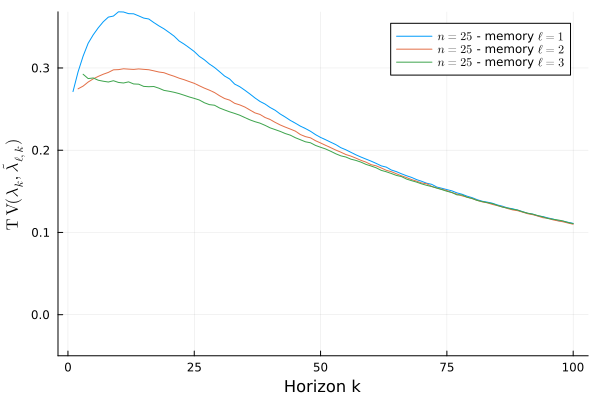

"/Users/adrienbanse/Desktop/05. CODE MISC/HSCC25_RP/figure_4.pdf"

In [17]:
p = plot(ylims=(-.05, :auto))
plot_experiment!(p, tv_list_3_1, (3+2)^2, 1, 100)
plot_experiment!(p, tv_list_3_2, (3+2)^2, 2, 100)
plot_experiment!(p, tv_list_3_3, (3+2)^2, 3, 100)
xlabel!(p, "Horizon k")
ylabel!(p, "\$ \\mathsf{TV}(\\lambda_{k}, \\tilde{\\lambda}_{\\ell, k})\$")
display(p)

savefig(p, "figure_4.pdf")

### Figure 5

In this experiment, we perform two experiments: 
1. We fix the partition with $p = 25$ with memory 1, which leads to $((p+2)^2)^{\ell+1} = 729^2 = 531 441$ transitions.
2. We fix the partition with $p = 7$ with memory 2, which also leads to $((p+2)^2)^{\ell+1} = 81^3 = 531 441$ transitions.

For both, we compute the TV distance for $k = 1, \dots, 100$.

Note: the execution of the following cell on a Macbook Pro M2 (16GB memory) takes roughly 40sec, and the figure will be saved as `figure_5.pdf`.

In [18]:
tv_list_25_1 = main_experiment(25, 1, 100)
tv_list_7_2 = main_experiment(7, 2, 100)

(p=25, l=1) 20/100
(p=25, l=1) 40/100
(p=25, l=1) 60/100
(p=25, l=1) 80/100
(p=25, l=1) 100/100
(p=25, l=1) done
--------
(p=7, l=2) 20/100
(p=7, l=2) 40/100
(p=7, l=2) 60/100
(p=7, l=2) 80/100
(p=7, l=2) 100/100
(p=7, l=2) done
--------


99-element Vector{Any}:
 0.23132620768238404
 0.24016813857594022
 0.24887713721571053
 0.25670981022976175
 0.2642363717181863
 0.26651935425447226
 0.27204025140144317
 0.2734507293550106
 0.2778807691320165
 0.2814627074536431
 ⋮
 0.12119475588813544
 0.11952334230927503
 0.11844713405987756
 0.11670415750287104
 0.11514824078493266
 0.11398091766220902
 0.11252877690780802
 0.11089894513889163
 0.10965689314030479

And we reproduce Figure 5.

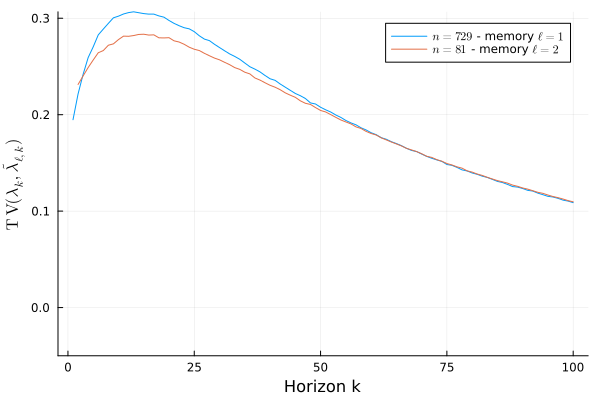

"/Users/adrienbanse/Desktop/05. CODE MISC/HSCC25_RP/figure_5.pdf"

In [19]:
p = plot(ylims=(-.05, :auto))
plot_experiment!(p, tv_list_25_1, (25+2)^2, 1, 100)
plot_experiment!(p, tv_list_7_2, (7+2)^2, 2, 100)
xlabel!(p, "Horizon k")
ylabel!(p, "\$ \\mathsf{TV}(\\lambda_{k}, \\tilde{\\lambda}_{\\ell, k})\$")
display(p)

savefig(p, "figure_5.pdf")